<a href="https://colab.research.google.com/github/HarxSan/AI-Agent/blob/main/AI_Agent_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community langchain_groq

In [2]:
import os
os.environ["LANGCHAIN_API_KEY"] = "xxx"
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="your-project-name"

In [3]:
from langchain_groq import ChatGroq

llm=ChatGroq(groq_api_key='xxx',model_name="model-name")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x798267fad910>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x79827c458410>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
import os

os.environ['TAVILY_API_KEY'] = 'xxx'

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "pillar_safe Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://bl

In [6]:
# Uncomment if you plan to use Claude as your llm
# ! pip install langchain_anthropic

In [7]:
! pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00


In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [18]:
from typing import Annotated
# from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langsmith import traceable
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)

@traceable
def chatbot(state: State, **kwargs):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [19]:
graph = graph_builder.compile(checkpointer=memory)

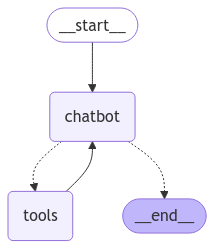

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [27]:
!apt-get install graphviz -y
!pip install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


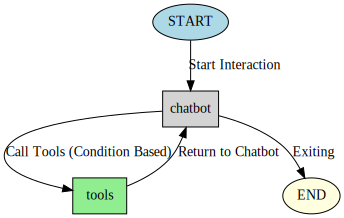

In [32]:
import graphviz

dot = graphviz.Digraph(format="png")

dot.node("START", shape="ellipse", style="filled", fillcolor="lightblue")
dot.node("chatbot", shape="box", style="filled", fillcolor="lightgray")
dot.node("tools", shape="box", style="filled", fillcolor="lightgreen")
dot.node("END", shape="ellipse", style="filled", fillcolor="lightyellow")

dot.edge("START", "chatbot", label="Start Interaction")
dot.edge("chatbot", "tools", label="Call Tools (Condition Based\)")
dot.edge("tools", "chatbot", label="Return to Chatbot")
dot.edge("chatbot", "END", label="Exiting")

dot.render("graph_output")
dot

In [21]:
config = {"configurable": {"thread_id": "1"}}

In [22]:
user_input = "Use tavily search engine if necessary, What is the expected crowd fot the mahakumb that is happening in 2025 in india?"

@traceable
def run_graph(input_msg):
  config = {"configurable": {"thread_id": "1"}}
  events = graph.stream(
      {"messages": [{"role": "user", "content": user_input}]},
      config,
      stream_mode="values",
  )
  return events

for event in run_graph(user_input):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Use tavily search engine if necessary, What is the expected crowd fot the mahakumb that is happening in 2025 in india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0047)
 Call ID: call_0047
  Args:
    query: Mahakumbh 2025 India expected crowd size
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://pib.gov.in/PressReleasePage.aspx?PRID=2101679", "content": "45 Crore Devotees at Maha Kumbh 2025 The Maha Kumbh 2025 has become one of the largest religious gatherings in history, with over 450 million (45 crore) devotees participating in the bathing rituals as of February 11, 2025. The state government was expecting the number of devotees to reach 45 crore in 45 days but this number has already been achieved within one month, with 15 days still re

In [23]:
config = {"configurable": {"thread_id": "1"}}

snapshot = graph.get_state(config)
snapshot.next

()

In [26]:
user_input = "Use tavily search engine if necessary, what did i ask previously?"
config = {"configurable": {"thread_id": "1"}}

for event in run_graph(user_input):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Use tavily search engine if necessary, what did i ask previously?
================================== Ai Message ==================================

You asked about the expected crowd for the Mahakumbh 2025 in India, and also what you had asked previously.
